# **Variational Autoencoders**


### **Datasets and Dataloaders**

In [ ]:
!mkdir XX

In [11]:
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F

transformations = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST('/hw4_data', transform=transformations, train=True, download=True) 
mnist_test = datasets.MNIST('/hw4_data', transform=transformations, train=False, download=True)

In [12]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=True)

## ** Encoder and Decoders **

In [13]:
from torch import nn
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    hidden_dim_1 = 400
    hidden_dim_2 = 400
    hidden_dim_3 = 200
    self.fc1 = nn.Linear(784,hidden_dim_1)
    self.activation_1 = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim_1,hidden_dim_2)
    self.activation_2 = nn.ReLU()  
    self.fc3 = nn.Linear(hidden_dim_2,hidden_dim_3)
    self.activation_3 = nn.ReLU()  
    self.mean = nn.Linear(hidden_dim_3,latent_dim)
    self.logvar = nn.Linear(hidden_dim_3,latent_dim)

  def forward(self, x):
    x = x.reshape(-1,784)
    x = self.activation_1(self.fc1(x))
    x = self.activation_2(self.fc2(x))
    x = self.activation_3(self.fc3(x))
    mean = self.mean(x)

    logvar = self.logvar(x)

    return mean, logvar

class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super(Decoder, self).__init__()
    hidden_dim_1 = 400
    hidden_dim_2 = 400
    hidden_dim_3 = 200
    self.fc1 = nn.Linear(latent_dim,hidden_dim_1)
    self.activation_1 = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim_1,hidden_dim_2)
    self.activation_2 = nn.ReLU()
    self.fc3 = nn.Linear(hidden_dim_2,hidden_dim_3)
    self.activation_3 = nn.ReLU()
    self.output = nn.Linear(hidden_dim_3,784)
    self.activation_output = nn.Sigmoid()

  def forward(self,x):
    x = self.activation_1(self.fc1(x))
    x = self.activation_2(self.fc2(x))
    x = self.activation_3(self.fc3(x))
    x = self.activation_output(self.output(x))
    return x

## **Training and loss functions**

In [14]:
def sample(mu, logvar):
  std = torch.exp(.5 * logvar)
  eps = torch.randn_like(mu)
  rv = torch.multiply(eps,std) + mu
  return rv

In [15]:
def vae_loss(x, x_hat, mu, logvar):
  # MSE LOSS + KL DIVERGENCE 
  x = x.reshape(-1,784)
  BCE_LOSS = F.binary_cross_entropy(x_hat, x, reduction='sum')
  KL_DIVERGENCE = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE_LOSS + KL_DIVERGENCE

In [16]:
torch.binary_cross_entropy_with_logits

<function _VariableFunctionsClass.binary_cross_entropy_with_logits>

In [17]:
from torch import optim

## YOUR CODE HERE ##
device = 'cuda:0'
encoder = Encoder(32).to(device)
decoder = Decoder(32).to(device)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params,lr=1e-3)

In [18]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 30):
  
  for epoch in range(num_epochs):
    epoch_loss = 0
    for data, _ in train_loader:
      optimizer.zero_grad()
      x = data.to(device)
      # run encoder
      mean, logvar = encoder(x)
      # sampling
      z_sample = sample(mean,logvar)
      # run decoder
      x_hat = decoder(z_sample)
      # run loss function
      loss = vae_loss(x,x_hat,mean,logvar)
      # backward loss
      loss.backward()
      # optimzer
      optimizer.step()
      epoch_loss += loss.item()

    print('EPOCH %d | LOSS %.4f'%(epoch + 1,epoch_loss))

In [19]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 50)

EPOCH 1 | LOSS 10041492.8818
EPOCH 2 | LOSS 8056521.2219
EPOCH 3 | LOSS 7647589.4058
EPOCH 4 | LOSS 7474336.4211
EPOCH 5 | LOSS 7302695.0535
EPOCH 6 | LOSS 7137567.1509
EPOCH 7 | LOSS 7036974.0186
EPOCH 8 | LOSS 6968590.3438
EPOCH 9 | LOSS 6910473.2908
EPOCH 10 | LOSS 6860881.9917
EPOCH 11 | LOSS 6815346.1943
EPOCH 12 | LOSS 6773726.6780
EPOCH 13 | LOSS 6730733.6125
EPOCH 14 | LOSS 6685377.1965
EPOCH 15 | LOSS 6651747.0527
EPOCH 16 | LOSS 6626193.6895
EPOCH 17 | LOSS 6600011.5725
EPOCH 18 | LOSS 6578897.7341
EPOCH 19 | LOSS 6561042.8635
EPOCH 20 | LOSS 6541274.4924
EPOCH 21 | LOSS 6525377.1213
EPOCH 22 | LOSS 6510392.6829
EPOCH 23 | LOSS 6496332.9880
EPOCH 24 | LOSS 6482545.7085
EPOCH 25 | LOSS 6470767.1050
EPOCH 26 | LOSS 6458425.3381
EPOCH 27 | LOSS 6451183.6174
EPOCH 28 | LOSS 6442384.9165
EPOCH 29 | LOSS 6433736.4631
EPOCH 30 | LOSS 6427669.8242
EPOCH 31 | LOSS 6420206.2295
EPOCH 32 | LOSS 6411966.9482
EPOCH 33 | LOSS 6402335.9521
EPOCH 34 | LOSS 6397516.3040
EPOCH 35 | LOSS 639414

## **Visualizing the VAE output**

In [20]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np
import torch

def create_interpolates(A, B, encoder, decoder):
  mean_1, logvar_1 = encoder(A.to(device))
  mean_2, logvar_2 = encoder(B.to(device))
  z_sample_1 = sample(mean_1,logvar_1).cpu().detach().numpy().squeeze()
  z_sample_2 = sample(mean_2,logvar_2).cpu().detach().numpy().squeeze()
  interpolations = []
  temp_sample_ = decoder(torch.Tensor(z_sample_1).to(device)).cpu().detach().numpy().reshape(28,28)
  interpolations.append(temp_sample_)
  for i in reversed(range(1,9)):
    temp_sample = z_sample_1 + (1 / i) * (z_sample_2 - z_sample_1)
    temp_sample_ = decoder(torch.Tensor(temp_sample).to(device)).cpu().detach().numpy().reshape(28,28)
    interpolations.append(temp_sample_)
  return interpolations

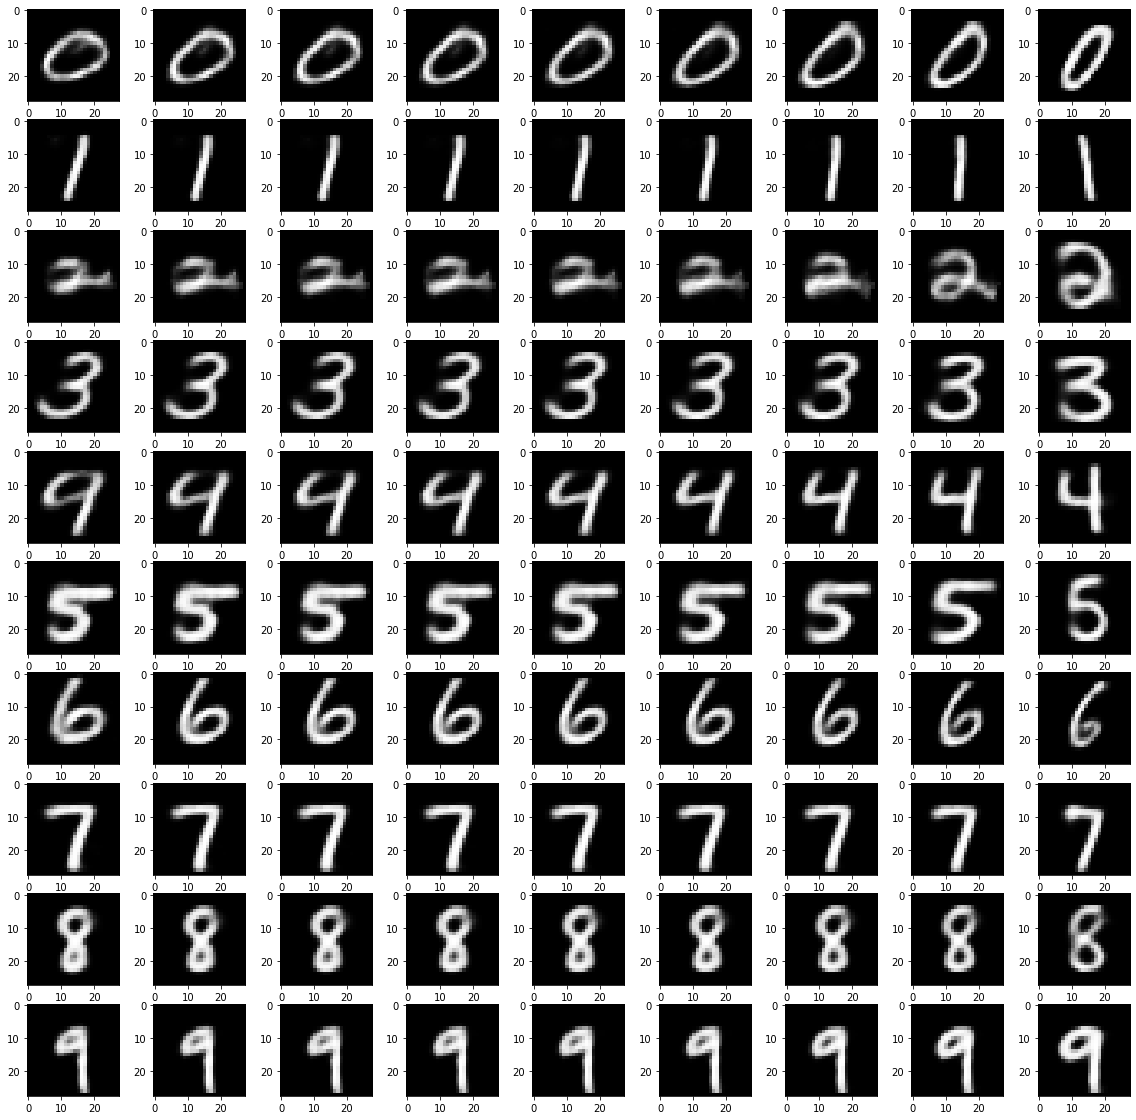

In [21]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
  for i in range(len(y)):
    if y[i].item() not in similar_pairs:
      similar_pairs[y[i].item()] = []
    if len(similar_pairs[y[i].item()])<2:
      similar_pairs[y[i].item()].append(x[i])
  
  done = True
  for i in range(10):
    if i not in similar_pairs or len(similar_pairs[i])<2:
      done = False
  
  if done:
    break

# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i

plt.figure(figsize=(20,20))
for k in similar_pairs.keys():
  interpolations = create_interpolates(similar_pairs[k][0].squeeze(),similar_pairs[k][1].squeeze(),encoder,decoder)
  for j in range(9):
    plt.subplot(10,9,9*(k+1)-(9-j-1))
    plt.imshow(interpolations[j],cmap='gray')
plt.show()

**For 10 pairs of MNIST test images of different digits selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.**

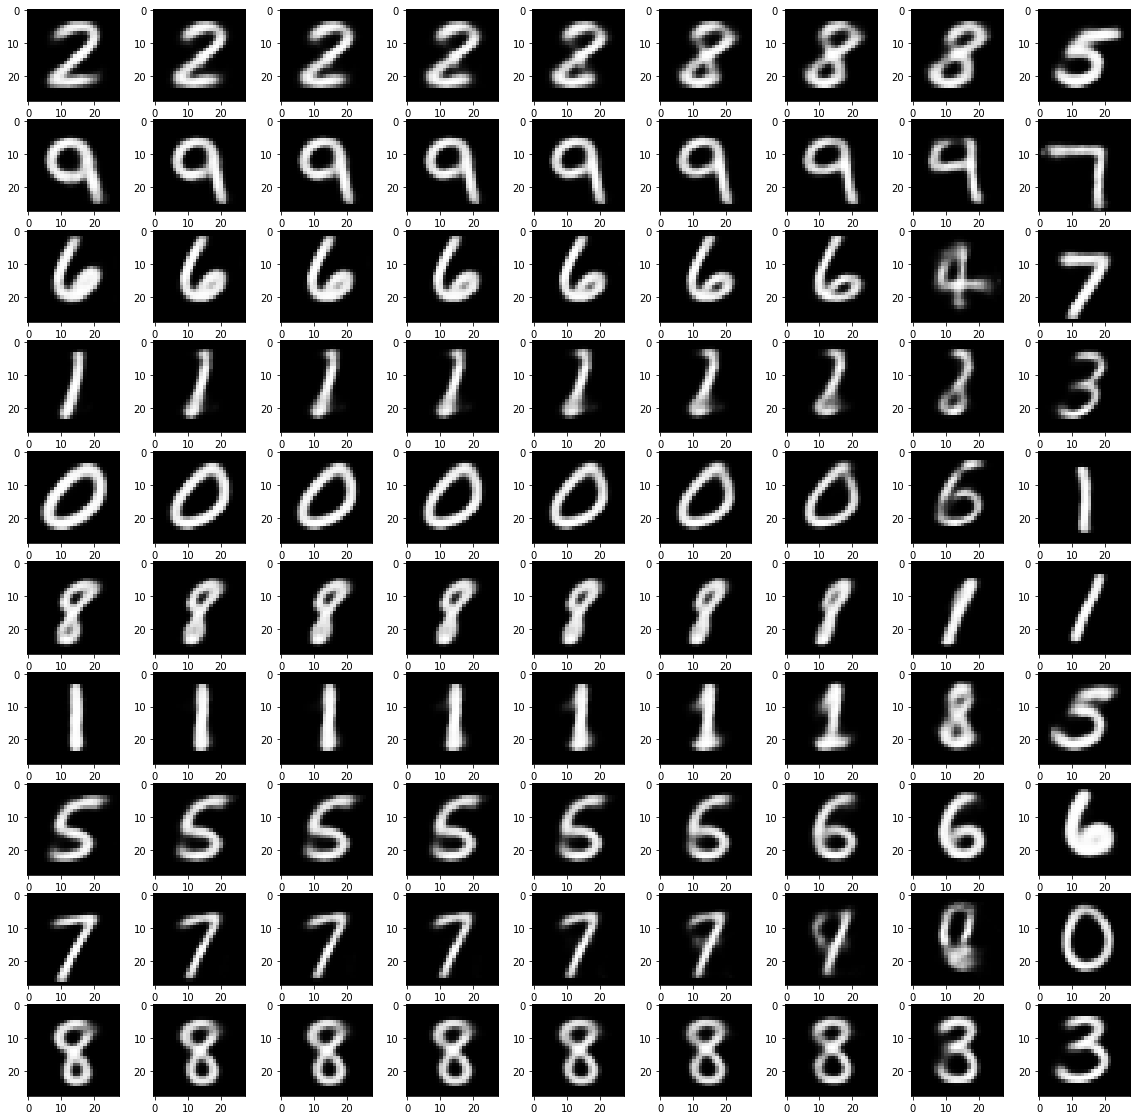

In [32]:
pairs = []
for batch_num, (x, y) in enumerate(test_loader):
    A_index = np.random.randint(0,batch_size)
    B_index = np.random.randint(0,batch_size)
    A = x[A_index]
    B = x[B_index]
    pairs.append([A,B])
    if batch_num == 9:
      break
      
plt.figure(figsize=(20,20))
for k in range(len(pairs)):
  interpolations = create_interpolates(pairs[k][0].squeeze(),pairs[k][1].squeeze(),encoder,decoder)
  for j in range(9):
    plt.subplot(10,9,9*(k+1)-(9-j-1))
    plt.imshow(interpolations[j],cmap='gray')
plt.show()
